# Tokenization

Токенизация — процесс разбиения текста на минимальные значимые единицы, токены. 

Исторически использовались простые методы: разделение по пробелам, регулярные выражения для выделения слов и знаков препинания, ручные правила для обработки сокращений. Однако такие подходы плохо масштабировались для языков с агглютинативной морфологией (например, русский или финский) и сложных словосочетаний. 

В современных NLP доминируют алгоритмы субсловной токенизации, такие как BPE (Byte Pair Encoding), которые балансируют между смысловой цельностью токенов и эффективным использованием словаря.

In [1]:
import re
import spacy
import numpy as np
import pandas as pd
from datasets import load_dataset

from dataclasses import dataclass
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from typing import List, Dict, Tuple
from collections import Counter, defaultdict

## Data Loading

Для демонстрации загрузим параллельный англо-русский корпус Tatoeba из библиотеки Hugging Face Datasets. 

Этот датасет содержит более 500 тысяч предложений-переводов, что делает его подходящим для задач машинного перевода. Примеры показывают короткие бытовые фразы: "Let's try something." → "Давайте что-нибудь попробуем!". 

Такой формат удобен для обучения моделей-трансформеров, которые работают с последовательностями ограниченной длины.

In [2]:
def load_translation_dataset():
    print("Loading Tatoeba en-ru...")
    try:
        dataset = load_dataset("Helsinki-NLP/tatoeba", lang1="en", lang2="ru", trust_remote_code=True)
        
    except Exception as e:
        print(f"Error while loading dataset: {e}")
        raise
    
    print("\nDataset structure:")
    print(dataset)
    
    print("\nData sample:")
    for i in range(2):
        print(f"EN: {dataset['train'][i]['translation']['en']}")
        print(f"RU: {dataset['train'][i]['translation']['ru']}\n")

    return dataset

In [3]:
dataset = load_translation_dataset()

Loading Tatoeba en-ru...


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

tatoeba.py:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 523656
    })
})

Data sample:
EN: For once in my life I'm doing a good deed... And it is useless.
RU: Один раз в жизни я делаю хорошее дело... И оно бесполезно.

EN: Let's try something.
RU: Давайте что-нибудь попробуем!



## Data Analyze

Анализ данных начинается с вычисления базовой статистики. 

Функция analyze_dataset показывает, что средняя длина английских предложений — 7.2 слова, русских — 6.2. Максимальные длины (30 и 28 слов) указывают на наличие выбросов, которые могут требовать обрезки. 

Гистограммы демонстрируют правостороннее распределение: большинство предложений короче 15 слов. Эти наблюдения влияют на выбор гиперпараметров модели, например, max_length=64 обеспечивает запас для паддинга, даже если реальные последовательности короче.

In [4]:
def analyze_dataset(dataset, n_samples: int = 1000):
    samples = dataset['train'].select(range(n_samples))
    
    en_lengths = [len(s['translation']['en'].split()) for s in samples]
    ru_lengths = [len(s['translation']['ru'].split()) for s in samples]
    
    print(f"Analysis based on first {n_samples} samples:")
    print(f"\nEnglish sentences:")
    print(f"Average length: {np.mean(en_lengths):.1f} words")
    print(f"Max length: {max(en_lengths)} words")
    print(f"Min length: {min(en_lengths)} words")
    
    print(f"\nRussian sentences:")
    print(f"Average length: {np.mean(ru_lengths):.1f} words")
    print(f"Max length: {max(ru_lengths)} words")
    print(f"Min length: {min(ru_lengths)} words")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(en_lengths, bins=30)
    plt.title('English Sentence Lengths')
    plt.xlabel('Words')
    
    plt.subplot(1, 2, 2)
    sns.histplot(ru_lengths, bins=30)
    plt.title('Russian Sentence Lengths')
    plt.xlabel('Words')
    
    plt.tight_layout()
    plt.show()
    
    return max(max(en_lengths), max(ru_lengths))

Analysis based on first 1000 samples:

English sentences:
Average length: 7.2 words
Max length: 30 words
Min length: 1 words

Russian sentences:
Average length: 6.2 words
Max length: 28 words
Min length: 1 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


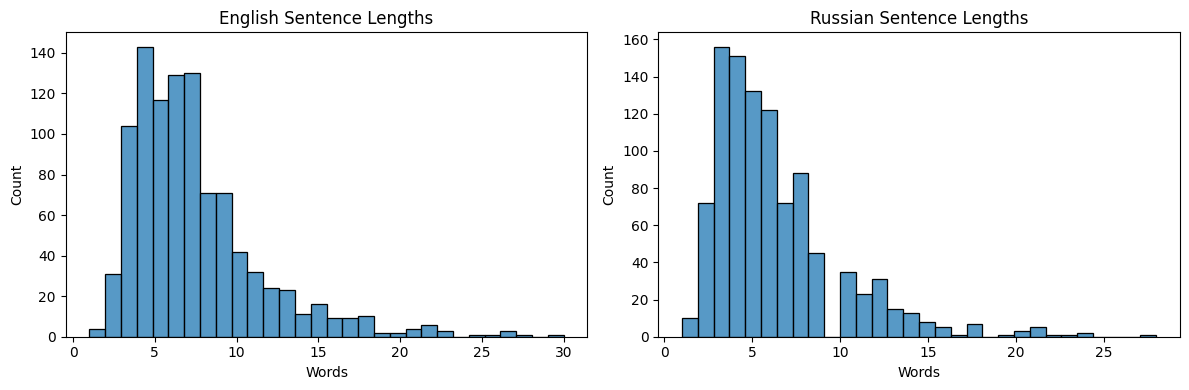

In [5]:
max_sentence_length = analyze_dataset(dataset)

## Токенизация

In [6]:
@dataclass
class BaseTokenizer:
    language: str
    vocab_size: int
    min_freq: int = 2
    special_tokens: List[str] = None
    
    def __post_init__(self):
        self.special_tokens = self.special_tokens or ["<PAD>", "<UNK>", "<BOS>", "<EOS>"]
        self.token2id = {token: idx for idx, token in enumerate(self.special_tokens)}
        self.id2token = {idx: token for idx, token in enumerate(self.special_tokens)}
    
    def preprocess_text(self, text: str) -> List[str]:
        tokens = re.findall(r"\w+[\w']*|['’][a-z]+|[^\w\s]", text.lower())
        return tokens
    
    def get_stats(self, examples: List[str]) -> Counter:
        counter = Counter()
        for text in examples:
            tokens = self.preprocess_text(text)
            counter.update(tokens)
        return counter

In [7]:
en_tokenizer = BaseTokenizer(language='en', vocab_size=32000)
ru_tokenizer = BaseTokenizer(language='ru', vocab_size=32000)

In [8]:
def analyze_token_statistics(dataset, tokenizer: BaseTokenizer, n_samples: int = 1000):
    samples = dataset['train'].select(range(n_samples))
    texts = [s['translation'][tokenizer.language] for s in samples]
    
    stats = tokenizer.get_stats(texts)
    
    print(f"\nToken statistics for {tokenizer.language}:")
    print(f"Total unique tokens: {len(stats)}")
    print("\nTop 10 most frequent tokens:")
    for token, count in stats.most_common(10):
        print(f"{token}: {count}")
    
    return stats

In [9]:
en_stats = analyze_token_statistics(dataset, en_tokenizer)
ru_stats = analyze_token_statistics(dataset, ru_tokenizer)


Token statistics for en:
Total unique tokens: 1337

Top 10 most frequent tokens:
.: 815
i: 351
you: 322
to: 280
the: 231
?: 185
a: 164
,: 160
": 146
is: 139

Token statistics for ru:
Total unique tokens: 2065

Top 10 most frequent tokens:
.: 806
,: 442
я: 294
не: 287
?: 185
это: 150
что: 149
ты: 124
!: 114
в: 112


## PBE токенизация

Реализация BPE включает несколько этапов. Сначала текст препроцессится: разбивается на слова и знаки препинания с помощью регулярных выражений. Например, фраза "I'm doing..." превращается в ["i'm", "doing", "..."]. 

Затем алгоритм итеративно сливает частые пары символов. На старте словарь состоит из отдельных символов (букв), но после 3000 слияний появляются субсловные единицы: "doing" → ["do", "ing"], "хорошее" → ["хорош", "ее"]. Обучение занимает некоторое время.

Однако даже после обучения заметны артефакты. Например, слово "useless" разбивается на ["us", "el", "ess"], а "бесполезно" — на ["бес", "пол", "ез", "но"]. Это следствие ограниченного числа слияний и отсутствия явного учета морфемных границ. 

В готовых токенизаторах (например, от Hugging Face) такие проблемы смягчаются за счет предобучения на огромных корпусах и десятков тысяч слияний.

In [10]:
@dataclass
class BPETokenizer(BaseTokenizer):
    def __post_init__(self):
        super().__post_init__()
        self.merges = {}
        self.vocab = set(self.special_tokens)
        
    def get_pairs(self, word: List[str]) -> List[Tuple[str, str]]:
        return [(word[i], word[i+1]) for i in range(len(word)-1)]
    
    def train(self, texts: List[str], num_merges: int):
        word_freqs = defaultdict(int)
        all_chars = set()  # Для сбора всех уникальных символов
        
        # Первый проход: сбор символов
        for text in texts:
            tokens = self.preprocess_text(text)
            for token in tokens:
                chars = list(token)
                word_freqs[' '.join(chars)] += 1  # Сохраняем исходное представление
                all_chars.update(chars)  # Добавляем символы в множество
        
        # Добавляем все символы в словарь
        for char in sorted(all_chars):
            if char not in self.token2id:
                idx = len(self.token2id)
                self.token2id[char] = idx
                self.id2token[idx] = char
                self.vocab.add(char)
        
        # Второй проход: подсчет частот слов
        word_freqs = defaultdict(int)
        for text in texts:
            tokens = self.preprocess_text(text)
            for token in tokens:
                chars = list(token)
                word = ' '.join(chars)
                word_freqs[word] += 1
        
        # Основной цикл слияний
        print(f"Training BPE tokenizer for {self.language}...")
        for i in tqdm(range(num_merges)):
            pair_freqs = defaultdict(int)
            
            # Подсчет частот пар
            for word, freq in word_freqs.items():
                symbols = word.split()
                pairs = self.get_pairs(symbols)
                for pair in pairs:
                    pair_freqs[pair] += freq
                    
            if not pair_freqs:
                break
                
            # Выбор наиболее частой пары
            best_pair = max(pair_freqs.items(), key=lambda x: x[1])[0]
            new_token = ''.join(best_pair)
            
            # Обновление словаря
            self.merges[best_pair] = new_token
            self.vocab.add(new_token)
            
            # Добавление нового токена в отображения
            if new_token not in self.token2id:
                idx = len(self.token2id)
                self.token2id[new_token] = idx
                self.id2token[idx] = new_token
                
            # Перестройка word_freqs с новыми слияниями
            new_word_freqs = defaultdict(int)
            for word, freq in word_freqs.items():
                symbols = word.split()
                i = 0
                new_symbols = []
                while i < len(symbols):
                    if i < len(symbols)-1 and (symbols[i], symbols[i+1]) == best_pair:
                        new_symbols.append(new_token)
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                new_word = ' '.join(new_symbols)
                new_word_freqs[new_word] += freq
                
            word_freqs = new_word_freqs
            
            # Логирование прогресса
            if (i + 1) % 1000 == 0:
                print(f"Merges completed: {i+1}/{num_merges}")
                print(f"Current vocabulary size: {len(self.token2id)}")
    
    def tokenize(self, text: str) -> List[int]:
        tokens = self.preprocess_text(text)
        result = [self.token2id['<BOS>']]
        
        for token in tokens:
            symbols = list(token)
            
            # Merge according to learned merges
            while len(symbols) > 1:
                pairs = self.get_pairs(symbols)
                pair_to_merge = None
                for pair in pairs:
                    if pair in self.merges:
                        pair_to_merge = pair
                        break
                if not pair_to_merge:
                    break
                    
                # Apply merge
                i = 0
                new_symbols = []
                while i < len(symbols):
                    if i < len(symbols)-1 and (symbols[i], symbols[i+1]) == pair_to_merge:
                        new_symbols.append(self.merges[pair_to_merge])
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                symbols = new_symbols
            
            # Add token IDs
            for symbol in symbols:
                if symbol in self.token2id:
                    result.append(self.token2id[symbol])
                else:
                    result.append(self.token2id['<UNK>'])
        
        result.append(self.token2id['<EOS>'])
        return result

In [11]:
en_bpe = BPETokenizer(language='en', vocab_size=32000)
ru_bpe = BPETokenizer(language='ru', vocab_size=32000)

n_samples = 80000 
train_samples = dataset['train'].select(range(n_samples))
en_texts = [s['translation']['en'] for s in train_samples]
ru_texts = [s['translation']['ru'] for s in train_samples]

en_bpe.train(en_texts, num_merges=3000)
ru_bpe.train(ru_texts, num_merges=3000)

# Проверка размера словаря
print(f"English vocabulary size: {len(en_bpe.token2id)}")
print(f"Russian vocabulary size: {len(ru_bpe.token2id)}")

Training BPE tokenizer for en...


  0%|          | 0/3000 [00:00<?, ?it/s]

Training BPE tokenizer for ru...


  0%|          | 0/3000 [00:00<?, ?it/s]

English vocabulary size: 3074
Russian vocabulary size: 3106


In [12]:
def test_tokenization(text: str, tokenizer: BPETokenizer):
    print(f"\nOriginal text: {text}")
    
    token_ids = tokenizer.tokenize(text)
    print(f"Token IDs: {token_ids}")
    
    tokens = [tokenizer.id2token[id] for id in token_ids]
    print(f"Tokens: {tokens}")
    
    return token_ids

In [13]:
en_sample = dataset['train'][0]['translation']['en']
ru_sample = dataset['train'][0]['translation']['ru']

print("English tokenization:")
en_tokens = test_tokenization(en_sample, en_bpe)

print("\nRussian tokenization:")
ru_tokens = test_tokenization(ru_sample, ru_bpe)

English tokenization:

Original text: For once in my life I'm doing a good deed... And it is useless.
Token IDs: [2, 236, 47, 647, 76, 121, 488, 220, 1009, 30, 273, 197, 91, 14, 14, 14, 127, 94, 78, 228, 973, 453, 14, 3]
Tokens: ['<BOS>', 'fo', 'r', 'once', 'in', 'my', 'life', "i'm", 'doing', 'a', 'good', 'de', 'ed', '.', '.', '.', 'and', 'it', 'is', 'us', 'el', 'ess', '.', '<EOS>']

Russian tokenization:

Original text: Один раз в жизни я делаю хорошее дело... И оно бесполезно.
Token IDs: [2, 643, 375, 208, 63, 874, 92, 274, 61, 91, 2160, 274, 75, 14, 14, 14, 69, 131, 75, 1770, 425, 337, 113, 14, 3]
Tokens: ['<BOS>', 'од', 'ин', 'раз', 'в', 'жизни', 'я', 'дел', 'а', 'ю', 'хорошее', 'дел', 'о', '.', '.', '.', 'и', 'он', 'о', 'бес', 'пол', 'ез', 'но', '.', '<EOS>']


## Подготовка батчей

Функция prepare_batch преобразует токенизированные последовательности в тензоры, пригодные для обучения. 

Каждое предложение дополняется до фиксированной длины (max_length=64) специальным токеном <PAD>, а маски внимания указывают модели игнорировать эти "пустые" позиции. 

Например, предложение из 24 токенов превращается в вектор длины 64, где 40 последних элементов — нули (ID <PAD>). Маскирование критично для трансформеров, так как механизм внимания иначе будет учитывать бессмысленные паддинг-токены, искажая веса.

In [14]:
def prepare_batch(batch: List[Dict], 
                 src_tokenizer: BPETokenizer, 
                 tgt_tokenizer: BPETokenizer,
                 max_length: int):
    src_texts = [item['translation']['en'] for item in batch]
    tgt_texts = [item['translation']['ru'] for item in batch]

    src_tokens = [src_tokenizer.tokenize(text) for text in src_texts]
    tgt_tokens = [tgt_tokenizer.tokenize(text) for text in tgt_texts]
    
    src_padded = []
    tgt_padded = []
    src_masks = []
    tgt_masks = []
    
    for src, tgt in zip(src_tokens, tgt_tokens):
        if len(src) > max_length:
            src_pad = src[:max_length]
            src_mask = [1] * max_length
        else:
            src_pad = src + [src_tokenizer.token2id['<PAD>']] * (max_length - len(src))
            src_mask = [1] * len(src) + [0] * (max_length - len(src))
        
        if len(tgt) > max_length:
            tgt_pad = tgt[:max_length]
            tgt_mask = [1] * max_length
        else:
            tgt_pad = tgt + [tgt_tokenizer.token2id['<PAD>']] * (max_length - len(tgt))
            tgt_mask = [1] * len(tgt) + [0] * (max_length - len(tgt))
        
        src_padded.append(src_pad)
        tgt_padded.append(tgt_pad)
        src_masks.append(src_mask)
        tgt_masks.append(tgt_mask)
    
    return {
        'src_tokens': np.array(src_padded),
        'tgt_tokens': np.array(tgt_padded),
        'src_mask': np.array(src_masks),
        'tgt_mask': np.array(tgt_masks)
    }


In [15]:
test_samples = dataset['train'].select(range(5))
prepared_data = prepare_batch(test_samples, en_bpe, ru_bpe, max_length=64)

print("Prepared batch shapes:")
for key, value in prepared_data.items():
    print(f"{key}: {value.shape}")

print("\nExample source tokens:")
print(prepared_data['src_tokens'][0])
print("\nCorresponding mask:")
print(prepared_data['src_mask'][0])

Prepared batch shapes:
src_tokens: (5, 64)
tgt_tokens: (5, 64)
src_mask: (5, 64)
tgt_mask: (5, 64)

Example source tokens:
[   2  236   47  647   76  121  488  220 1009   30  273  197   91   14
   14   14  127   94   78  228  973  453   14    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

Corresponding mask:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
def verify_bpe_tokenization(tokenizer: BPETokenizer, text: str):
    """Подробная проверка процесса токенизации"""
    print(f"Original text: {text}")
    
    base_tokens = tokenizer.preprocess_text(text)
    print(f"\nBase tokenization: {base_tokens}")
    
    print(f"\nNumber of merges learned: {len(tokenizer.merges)}")
    print("Sample merges (first 5):")
    for pair, merged in list(tokenizer.merges.items())[:5]:
        print(f"{pair} -> {merged}")
    
    print(f"\nVocabulary size: {len(tokenizer.token2id)}")
    print("Sample vocabulary items (first 10):")
    for token, idx in list(tokenizer.token2id.items())[:10]:
        print(f"{token}: {idx}")
    
    tokens = tokenizer.tokenize(text)
    decoded = [tokenizer.id2token[id] for id in tokens]
    
    print(f"\nFinal tokenization:")
    print(f"Token IDs: {tokens}")
    print(f"Decoded tokens: {decoded}")

print("Testing English tokenizer:")
verify_bpe_tokenization(en_bpe, dataset['train'][0]['translation']['en'])

Testing English tokenizer:
Original text: For once in my life I'm doing a good deed... And it is useless.

Base tokenization: ['for', 'once', 'in', 'my', 'life', "i'm", 'doing', 'a', 'good', 'deed', '.', '.', '.', 'and', 'it', 'is', 'useless', '.']

Number of merges learned: 3000
Sample merges (first 5):
('h', 'e') -> he
('t', 'he') -> the
('i', 'n') -> in
('o', 'u') -> ou
('i', 's') -> is

Vocabulary size: 3074
Sample vocabulary items (first 10):
<PAD>: 0
<UNK>: 1
<BOS>: 2
<EOS>: 3
!: 4
": 5
$: 6
%: 7
&: 8
': 9

Final tokenization:
Token IDs: [2, 236, 47, 647, 76, 121, 488, 220, 1009, 30, 273, 197, 91, 14, 14, 14, 127, 94, 78, 228, 973, 453, 14, 3]
Decoded tokens: ['<BOS>', 'fo', 'r', 'once', 'in', 'my', 'life', "i'm", 'doing', 'a', 'good', 'de', 'ed', '.', '.', '.', 'and', 'it', 'is', 'us', 'el', 'ess', '.', '<EOS>']


## Hugging Face

Использование готового токенизатора через AutoTokenizer демонстрирует преимущества стандартизированных инструментов. 

Модель opus-mt-en-ru использует предобученный BPE-словарь, оптимизированный для пары языков. Токенизатор автоматически добавляет служебные токены (например, <s> для начала предложения), обрабатывает регистр и редкие символы. 

При обработке датасета функция map применяет токенизацию параллельно ко всем примерам, что ускоряет работу за счет батчинга.

In [17]:
from transformers import AutoTokenizer

def prepare_data_with_hf(
    dataset,
    model_name: str = "Helsinki-NLP/opus-mt-en-ru",
    max_length: int = 128,
    batch_size: int = 32
):
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def preprocess_function(examples):
        source_texts = [item['en'] for item in examples['translation']]
        target_texts = [item['ru'] for item in examples['translation']]
        
        source_encoding = tokenizer(
            source_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='np'
        )
        
        target_encoding = tokenizer(
            target_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='np'
        )
        
        return {
            'input_ids': source_encoding['input_ids'],
            'attention_mask': source_encoding['attention_mask'],
            'labels': target_encoding['input_ids'],
            'decoder_attention_mask': target_encoding['attention_mask']
        }
    
    processed_dataset = dataset['train'].map(
        preprocess_function,
        batched=True,
        batch_size=batch_size,
        remove_columns=dataset['train'].column_names
    )
    
    return processed_dataset, tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [18]:
processed_data, hf_tokenizer = prepare_data_with_hf(dataset)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/523656 [00:00<?, ? examples/s]

## Test

In [19]:
def print_custom_bpe_data_shape(prepared_data):
    print("\n" + "="*50)
    print("Custom BPE Tokenizer Data Structure:")
    print("Shape of prepared batches:")
    for key, array in prepared_data.items():
        print(f"{key}: {array.shape} (dtype: {array.dtype})")
    
    print("\nSample data from first batch:")
    print("Source tokens (first example):")
    print(prepared_data['src_tokens'][0])
    print("\nTarget tokens (first example):")
    print(prepared_data['tgt_tokens'][0])
    print("\nSource mask (first example):")
    print(prepared_data['src_mask'][0])
    print("="*50 + "\n")

def print_hf_data_details(processed_dataset, tokenizer):
    print("\n" + "="*50)
    print("Hugging Face Tokenizer Data Structure:")
    print(f"Dataset features: {processed_dataset.features}")
    print(f"Number of examples: {len(processed_dataset)}")
    
    first_example = processed_dataset[0]
    print("\nFirst example details:")
    print("Input IDs shape:", len(first_example['input_ids']))
    print("Decoded input:", tokenizer.decode(first_example['input_ids'], skip_special_tokens=True))
    print("Labels shape:", len(first_example['labels']))
    print("Decoded labels:", tokenizer.decode(first_example['labels'], skip_special_tokens=True))
    print("Attention mask sample:", first_example['attention_mask'][:10])
    print("="*50 + "\n")

In [20]:
test_samples = dataset['train'].select(range(5))
prepared_data = prepare_batch(test_samples, en_bpe, ru_bpe, max_length=64)
print_custom_bpe_data_shape(prepared_data)


processed_data, hf_tokenizer = prepare_data_with_hf(dataset)
print_hf_data_details(processed_data, hf_tokenizer)


Custom BPE Tokenizer Data Structure:
Shape of prepared batches:
src_tokens: (5, 64) (dtype: int64)
tgt_tokens: (5, 64) (dtype: int64)
src_mask: (5, 64) (dtype: int64)
tgt_mask: (5, 64) (dtype: int64)

Sample data from first batch:
Source tokens (first example):
[   2  236   47  647   76  121  488  220 1009   30  273  197   91   14
   14   14  127   94   78  228  973  453   14    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

Target tokens (first example):
[   2  643  375  208   63  874   92  274   61   91 2160  274   75   14
   14   14   69  131   75 1770  425  337  113   14    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

Source mask (first example):
[1 1 1 1 1 1 1 1 1 1 1 